#Import libraries

In [14]:
# Librerie base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Librosa per audio
import librosa
import librosa.display

# IPython display per mostrare Audio e DataFrame in Jupyter
import IPython

# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Progress bar
from tqdm import tqdm
import seaborn as sns


# 2. Fetch the Dataset

*   ESC-50: a dataset for Environmental Sound Classification (https://github.com/karolpiczak/ESC-50, https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)
 * 50 classes,  40 files per class, 5s clips
*   Download & unzip the dataset running the cell below. This will take a minute. You will see the new files on the left (folder icon).

In [3]:
#!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
#!unzip master.zip
#!rm master.zip

---

# 3. Metadata and analysis I

***Tasks:***
* Use pandas to read the csv file in *ESC-50-master/meta/*
* Print the first elements of the csv. Pandas has a standard function for this.
* Print the list of *unique* class labels in the dataset, and check whether there really are 50 of them

In [15]:
# Setup some filepaths
fn = 'ESC-50-master/meta/esc50.csv'

df = pd.read_csv(fn)
df.head()

unique_categories = np.unique(df['category'])
print(unique_categories)
print(len(unique_categories))

['airplane' 'breathing' 'brushing_teeth' 'can_opening' 'car_horn' 'cat'
 'chainsaw' 'chirping_birds' 'church_bells' 'clapping' 'clock_alarm'
 'clock_tick' 'coughing' 'cow' 'crackling_fire' 'crickets' 'crow'
 'crying_baby' 'dog' 'door_wood_creaks' 'door_wood_knock'
 'drinking_sipping' 'engine' 'fireworks' 'footsteps' 'frog'
 'glass_breaking' 'hand_saw' 'helicopter' 'hen' 'insects'
 'keyboard_typing' 'laughing' 'mouse_click' 'pig' 'pouring_water' 'rain'
 'rooster' 'sea_waves' 'sheep' 'siren' 'sneezing' 'snoring' 'thunderstorm'
 'toilet_flush' 'train' 'vacuum_cleaner' 'washing_machine' 'water_drops'
 'wind']
50


---

# 4. Metadata and analysis II

* View and listen to some examples in the dataset to get a "feeling" for the sound classes.

dog
chirping_birds
vacuum_cleaner


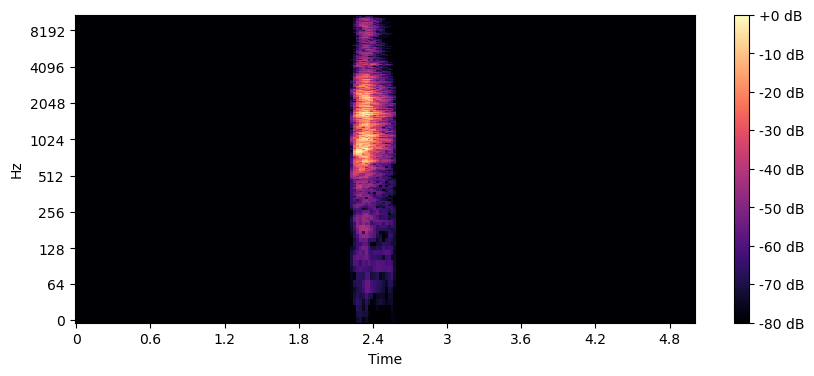

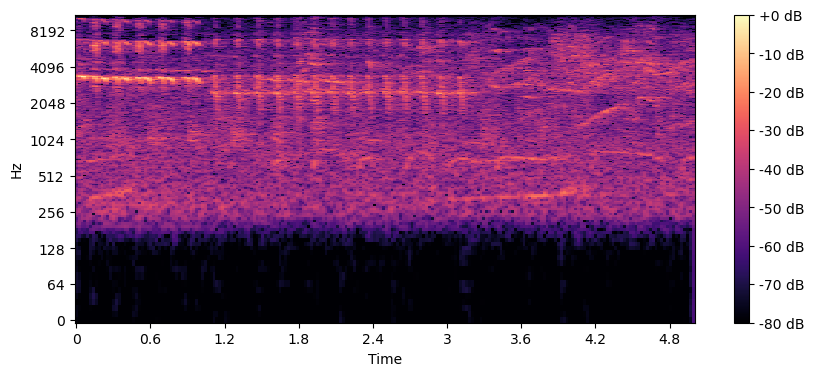

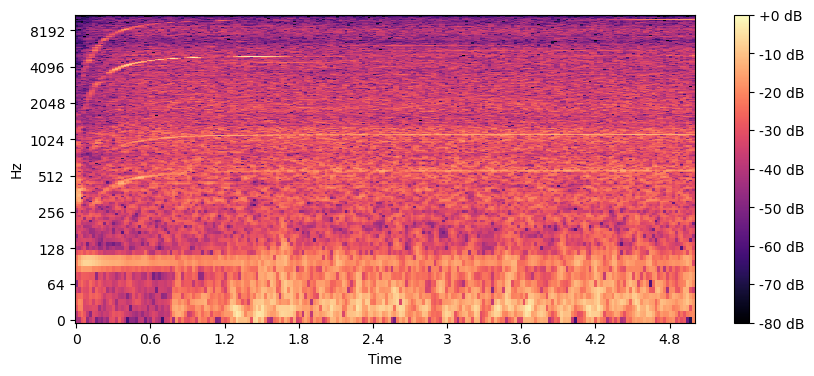

In [16]:
# Show audio player for each file
audio_path = 'ESC-50-master/audio/'
audio0 = audio_path + df['filename'][0]
audio1 = audio_path + df['filename'][1]
audio2 = audio_path + df['filename'][2]

print(df['category'][0])
print(df['category'][1])
print(df['category'][2])

IPython.display.display(IPython.display.Audio(audio0))
IPython.display.display(IPython.display.Audio(audio1))
IPython.display.display(IPython.display.Audio(audio2))

# Plot STFT specs
y0, sr0 = librosa.load(audio0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y0)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr0, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

y1, sr1 = librosa.load(audio1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

y2, sr2 = librosa.load(audio2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()



---

# 5. ESC-5: Curation

Let's select 5 classes (*our_classes*) from ESC-50 to make things a bit faster.

***Tasks:***
* Collect all files that belong to *our_classes*.
* Put the files and their respective classes in separate lists. Make sure their indices are equal (meaning: the value at index 3 of list *A* is related to the value at index 3 of list *B*).
  * Idea 1: Use *df.values* to iterate over the rows of the csv
  * Idea 2: Use *df.query('category in @our_classes')*
* Print the first 5 elements of each list as (file, class)-tuples. Also, print the overall lengths of the lists.

In [18]:
#print(np.unique(df['category']))

selected_classes = ['crying_baby','dog','rain','rooster','sneezing']

esc5_files = []
esc5_classes = []

df2 = df.query('category in @selected_classes')
esc5_files = df2['filename'].values
esc5_classes = df2['category'].values

print(list(zip(esc5_files[:5], esc5_classes[:5])))
print(f'Lenght esc5_files: {len(esc5_files)}, Lenght esc5_classes: {len(esc5_classes)}')


[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-17367-A-10.wav', 'rain'), ('1-187207-A-20.wav', 'crying_baby'), ('1-211527-A-20.wav', 'crying_baby')]
Lenght esc5_files: 200, Lenght esc5_classes: 200


---

# 6. ESC-5: Dataset splitting

***Tasks:***
* Split the dataset into *train* and *test* subsets: split ratio is 80%/20%, and random state 1337.
  * Use a suitable straight-forward function from sklearn.
* Print the first 3 elements of the resulting *X_train*.
* Print the overall lengths of the resulting lists. Are they aligned with the ratio?

Result: ESC-5 is ready. We have a train and test set consisting of file lists and their respective classes.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(esc5_files, esc5_classes,
                                                    train_size=0.8,
                                                    test_size=0.2, random_state=1337)

print(list(zip(X_train[:3], y_train[:3])))
print(f'Lenght X_train: {len(X_train)}, Lenght y_train: {len(y_train)}')
print(f'Lenght Y_test: {len(X_test)}, Lenght y_test: {len(y_test)}')


[('5-203128-A-0.wav', 'dog'), ('4-181286-A-10.wav', 'rain'), ('3-157615-A-10.wav', 'rain')]
Lenght X_train: 160, Lenght y_train: 160
Lenght Y_test: 40, Lenght y_test: 40


---
# 7. ESC-5: Create mel spectrograms

We need to compute features and corresponding labels for each file in our ESC-5.

***Tasks:***
* Define a function that does the following (in this order!):
  * takes input parameters: *X_train* (list of filenames), *y_train* (list of classes)
  * loops over *X_train* (hint: *enumerate* it), and loads each file (.wav) using librosa
  * creates the mel spectrogram from the loaded .wav samples
  * normalizes the mel spec by dividing it through the number of given *mel_bands*.
  * transposes the mel spec
  * appends the features (mel spec) to a feature tensor
  * creates a target vector consisting of as many values as there are frames
    * hint: use .shape to see which value you need
  * each value inside the vector must correspond to the index of the class in *our_classes*
    * hint: remember *numpy.ones(...)* ?
    * hint: use *.index(...)* here. Not ideal, but works here.
  * appends the targets to a target tensor
  * stacks the large feature and target lists appropriately
  * returns the tensors
* Finally, print the shapes of all 4 arrays.

100%|██████████| 40/40 [00:00<00:00, 104.90it/s]



🔎 KNN con 10 MFCC:
✅ Train Accuracy: 0.9681
✅ Test Accuracy: 0.6056
⏱️ Training Time: 0.03 s


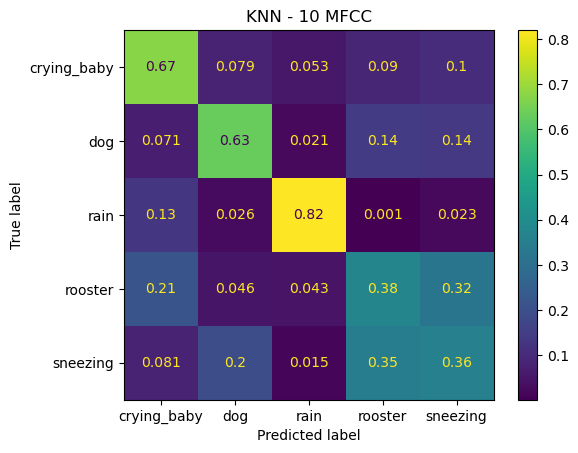


🔎 SVM Linear con 10 MFCC:
✅ Train Accuracy: 0.6483
✅ Test Accuracy: 0.6157
⏱️ Training Time: 52.90 s


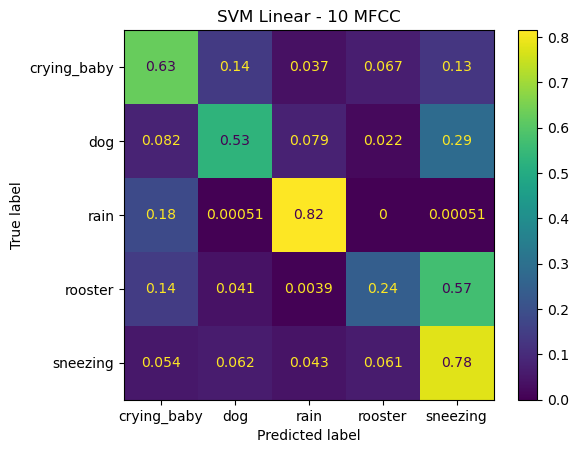


🔎 SVM RBF con 10 MFCC:
✅ Train Accuracy: 0.7841
✅ Test Accuracy: 0.6426
⏱️ Training Time: 27.45 s


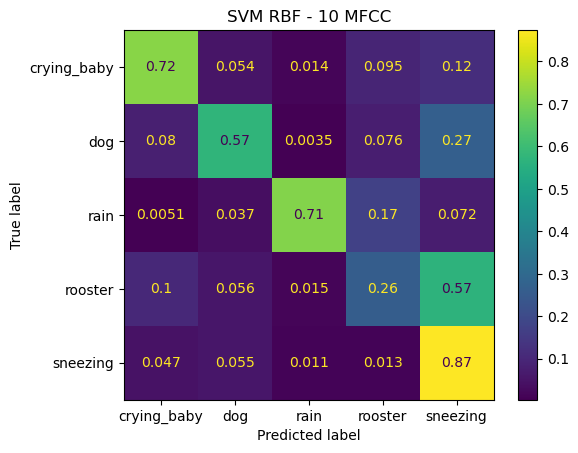


🔎 Logistic Regression con 10 MFCC:
✅ Train Accuracy: 0.6338
✅ Test Accuracy: 0.6057
⏱️ Training Time: 0.17 s


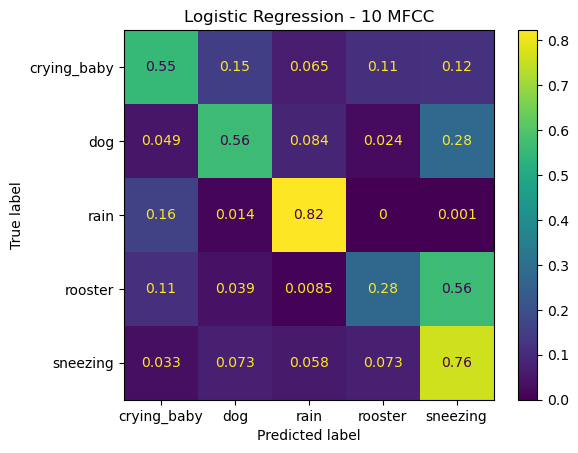


🔎 Random Forest con 10 MFCC:
✅ Train Accuracy: 1.0000
✅ Test Accuracy: 0.6182
⏱️ Training Time: 11.79 s


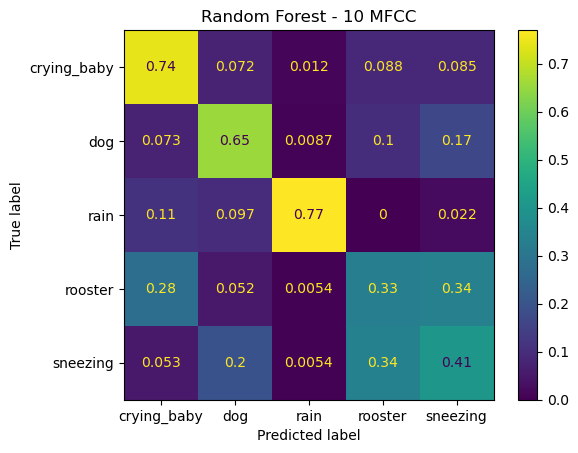


🔎 KNN con 20 MFCC:


/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


✅ Train Accuracy: 0.9770
✅ Test Accuracy: 0.6127
⏱️ Training Time: 0.01 s


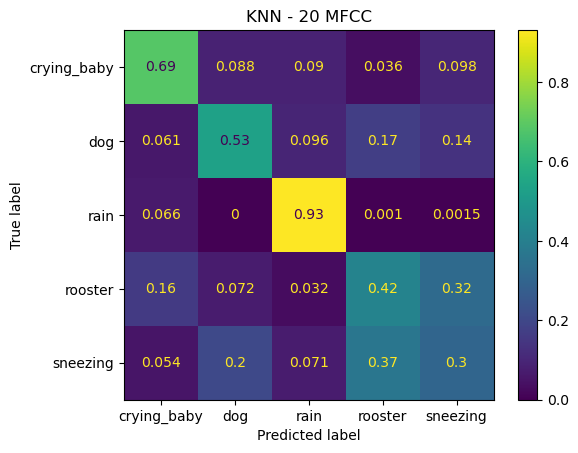


🔎 SVM Linear con 20 MFCC:
✅ Train Accuracy: 0.6674
✅ Test Accuracy: 0.6272
⏱️ Training Time: 64.47 s


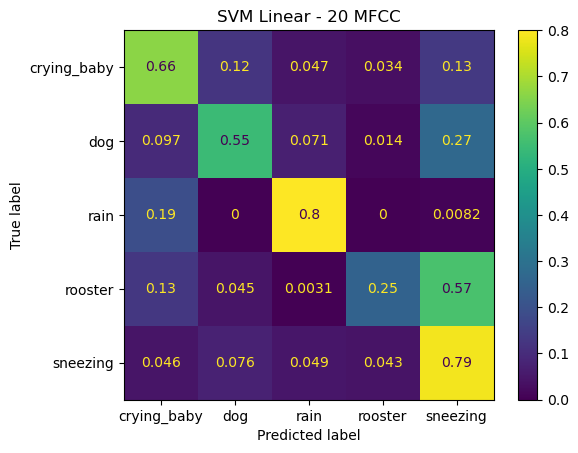


🔎 SVM RBF con 20 MFCC:
✅ Train Accuracy: 0.8113
✅ Test Accuracy: 0.7039
⏱️ Training Time: 28.90 s


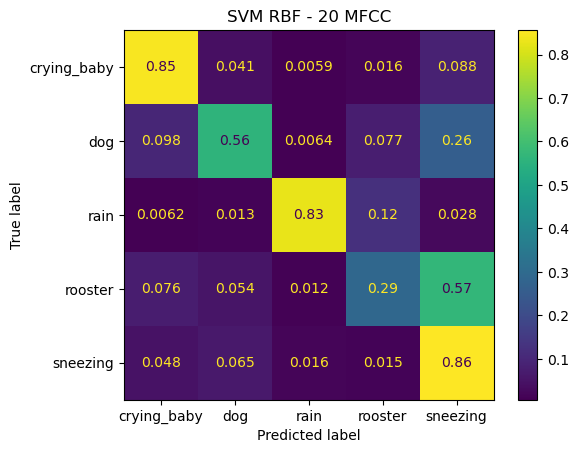


🔎 Logistic Regression con 20 MFCC:
✅ Train Accuracy: 0.6458
✅ Test Accuracy: 0.6306
⏱️ Training Time: 0.24 s


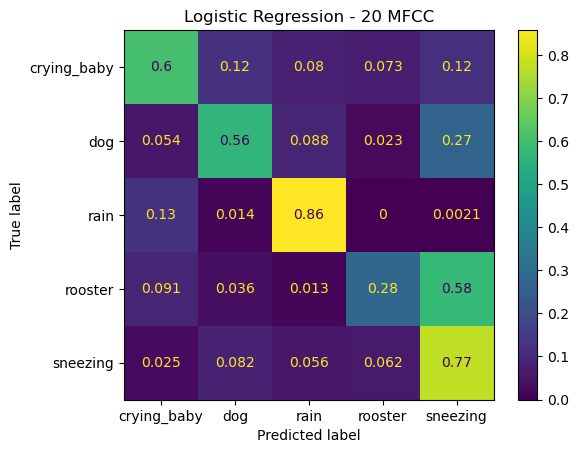


🔎 Random Forest con 20 MFCC:
✅ Train Accuracy: 1.0000
✅ Test Accuracy: 0.6730
⏱️ Training Time: 15.08 s


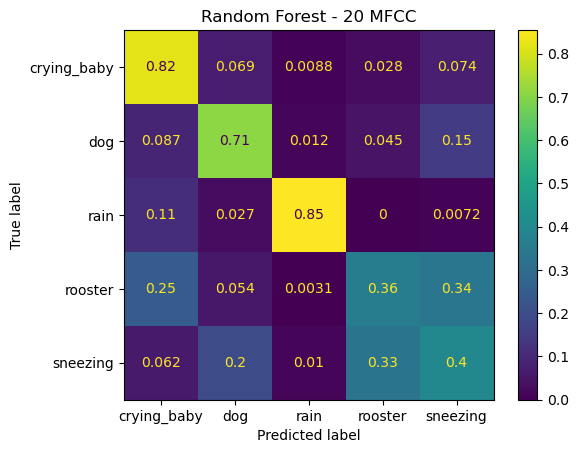


📊 Riepilogo Finale delle Performance:


,Model,MFCC,Train Accuracy,Test Accuracy,Training Time (s)
0,KNN,10,0.9681,0.6056,0.03
1,SVM Linear,10,0.6483,0.6157,52.90
2,SVM RBF,10,0.7841,0.6426,27.45
3,Logistic Regression,10,0.6338,0.6057,0.17
4,Random Forest,10,1.0000,0.6182,11.79
5,KNN,20,0.9770,0.6127,0.01
6,SVM Linear,20,0.6674,0.6272,64.47
7,SVM RBF,20,0.8113,0.7039,28.90
8,Logistic Regression,20,0.6458,0.6306,0.24
9,Random Forest,20,1.0000,0.6730,15.08


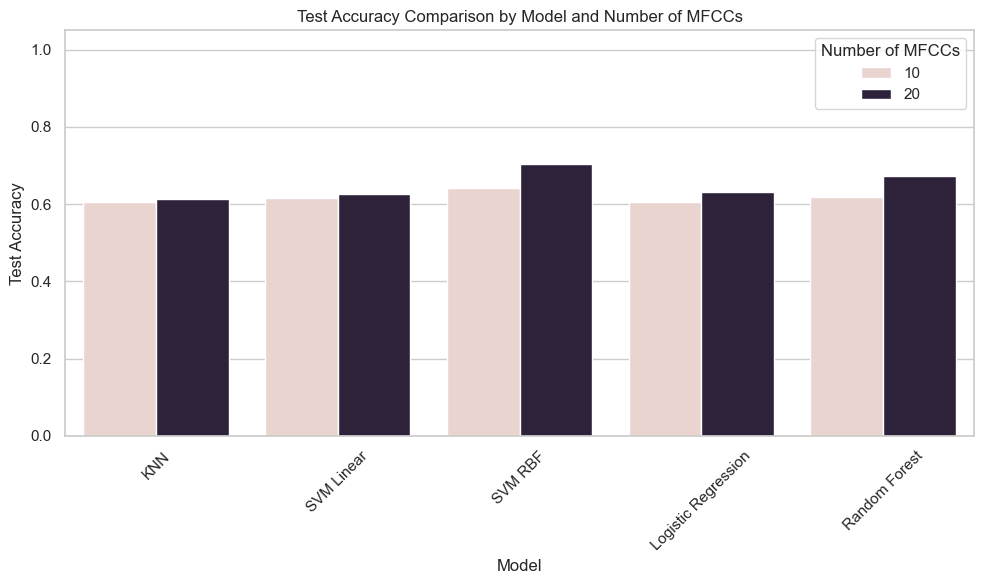

In [20]:
def extract_mfcc_features(X_files, y_labels, n_mfcc=13):
    X = []
    y = []

    for i, file in enumerate(tqdm(X_files)):
        signal, sr = librosa.load(audio_path + file)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.T  # (frames, coeffs)
        X.append(mfcc)
        y.append(np.ones(mfcc.shape[0]) * selected_classes.index(y_labels[i]))

    X = np.vstack(X)
    y = np.hstack(y)
    return X, y

X_train_10, y_train_10 = extract_mfcc_features(X_train, y_train, n_mfcc=10)
X_test_10, y_test_10 = extract_mfcc_features(X_test, y_test, n_mfcc=10)

X_train_20, y_train_20 = extract_mfcc_features(X_train, y_train, n_mfcc=20)
X_test_20, y_test_20 = extract_mfcc_features(X_test, y_test, n_mfcc=20)




scaler_10 = StandardScaler()
X_train_10_scaled = scaler_10.fit_transform(X_train_10)
X_test_10_scaled = scaler_10.transform(X_test_10)

scaler_20 = StandardScaler()
X_train_20_scaled = scaler_20.fit_transform(X_train_20)
X_test_20_scaled = scaler_20.transform(X_test_20)


results_summary = []

def train_and_evaluate(X_train, y_train, X_test, y_test, model, model_name, mfcc_count):
    print(f"\n🔎 {model_name} con {mfcc_count} MFCC:")
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"✅ Train Accuracy: {train_score:.4f}")
    print(f"✅ Test Accuracy: {test_score:.4f}")
    print(f"⏱️ Training Time: {duration:.2f} s")

    results_summary.append({
        'Model': model_name,
        'MFCC': mfcc_count,
        'Train Accuracy': round(train_score, 4),
        'Test Accuracy': round(test_score, 4),
        'Training Time (s)': round(duration, 2)
    })

    # Confusion matrix
    cm = confusion_matrix(y_true=y_test, y_pred=model.predict(X_test), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
    disp.plot()
    plt.title(f"{model_name} - {mfcc_count} MFCC")
    plt.show()


models = [
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (SVC(kernel='linear'), "SVM Linear"),
    (SVC(kernel='rbf'), "SVM RBF"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest")
]


# MFCC = 10
for model, name in models:
    train_and_evaluate(X_train_10_scaled, y_train_10, X_test_10_scaled, y_test_10, model, name, mfcc_count=10)

# MFCC = 20
for model, name in models:
    train_and_evaluate(X_train_20_scaled, y_train_20, X_test_20_scaled, y_test_20, model, name, mfcc_count=20)


results_df = pd.DataFrame(results_summary)
print("\n📊 Riepilogo Finale delle Performance:")
display(results_df)

# Set visual style
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(10, 6))

# Bar plot: Test Accuracy by Model and MFCC count
sns.barplot(data=results_df, x='Model', y='Test Accuracy', hue='MFCC')

# Chart title and labels
plt.title('Test Accuracy Comparison by Model and Number of MFCCs')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.05)  # Y-axis from 0 to 100%
plt.legend(title='Number of MFCCs')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()







Shape X_train_ready: (34560, 128)
Shape y_train_ready: (34560,)
Shape X_test_ready: (8640, 128)
Shape y_test_ready: (8640,)


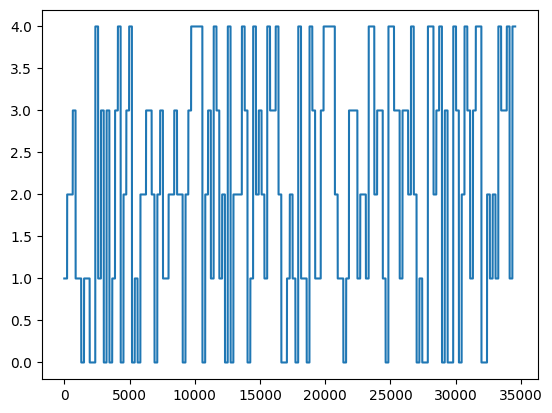

In [51]:
print(f'Shape X_train_ready: {X_train_ready.shape}')
print(f'Shape y_train_ready: {y_train_ready.shape}')
print(f'Shape X_test_ready: {X_test_ready.shape}')
print(f'Shape y_test_ready: {y_test_ready.shape}')

plt.plot(y_train_ready)

In [52]:
np.isnan(X_train_ready)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

---

# 8. ESC-5: Train a nearest neighbor classifier

***Tasks:***
* Standardize the features from step 7 using sklearn.
* Use the features and targets to train (*fit*) a kNN-classifier from sklearn, with 5 neighbors and uniform weighting.
* Print the scores on the train set and test set, rounded to 4 decimals. (This will take some time!)


In [53]:
print('Scaling ...')
scaler = StandardScaler()
scaler.fit(X_train_ready)

X_train_scaled = scaler.transform(X_train_ready)
X_test_scaled = scaler.transform(X_test_ready)

Scaling ...


In [55]:
print('Classification ...')
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train_scaled, y_train_ready)

print('Evaluation')
print(f'Train score: {np.round(knn.score(X_train_scaled, y_train_ready), decimals=4)}')
print(f'Test score: {np.round(knn.score(X_test_scaled, y_test_ready), decimals=4)}')

Classification ...
Evaluation
Train score: 0.7648
Test score: 0.5781


---

# 9. ESC-5: Plot the confusion matrix
We want to learn more about our classifier. How well does it perform per class?

***Tasks:***
* Using scikit-learn, create a confusion matrix of our classifier over the test set
* Normalize the rows, use 'our_classes' as axes tick values
* Display the plot

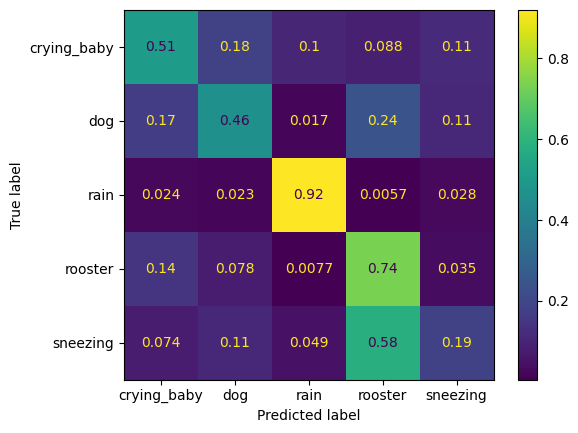

In [57]:
cm = confusion_matrix(y_true=y_test_ready, y_pred=knn.predict(X_test_scaled), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot()
plt.show()
